# Прогнозирование показателей концентрации метана, собранные подземными датчиками угольной шахты

## 1. Импорт библиотек и загрузка данных

### Импортируем необходимые библиотеки

In [289]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import seaborn as sns

### Загрузим данные из файла

In [330]:
df = pd.read_csv('./methane_data.csv')

### Посмотрим, что из себя представляет датасет
Выведем первые 5 сторок

In [331]:
df.head()

,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
0,2014,3,2,0,0,0,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,4.0,6.0,4.0,0.0,0.0,0.0
1,2014,3,2,0,0,1,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,4.0,5.0,4.0,0.0,0.0,0.0
2,2014,3,2,0,0,2,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,0.0
3,2014,3,2,0,0,3,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,0.0
4,2014,3,2,0,0,4,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,0.0


Размер датасета

In [332]:
df.shape

(9199930, 34)

Колонки датасета

In [333]:
df.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'second', 'AN311', 'AN422',
       'AN423', 'TP1721', 'RH1722', 'BA1723', 'TP1711', 'RH1712', 'BA1713',
       'MM252', 'MM261', 'MM262', 'MM263', 'MM264', 'MM256', 'MM211', 'CM861',
       'CR863', 'P_864', 'TC862', 'WM868', 'AMP1_IR', 'AMP2_IR', 'DMP3_IR',
       'DMP4_IR', 'AMP5_IR', 'F_SIDE', 'V'],
      dtype='object')

## 2. Понимаем, какая перед нами задача

In [334]:
df.head()

,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
0,2014,3,2,0,0,0,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,4.0,6.0,4.0,0.0,0.0,0.0
1,2014,3,2,0,0,1,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,4.0,5.0,4.0,0.0,0.0,0.0
2,2014,3,2,0,0,2,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,0.0
3,2014,3,2,0,0,3,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,0.0
4,2014,3,2,0,0,4,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,0.0


### Типы данных
Смотрим типы данных каждого признака. 

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9199930 entries, 0 to 9199929
Data columns (total 34 columns):
 #   Column   Dtype  
---  ------   -----  
 0   year     int64  
 1   month    int64  
 2   day      int64  
 3   hour     int64  
 4   minute   int64  
 5   second   int64  
 6   AN311    float64
 7   AN422    float64
 8   AN423    float64
 9   TP1721   float64
 10  RH1722   int64  
 11  BA1723   float64
 12  TP1711   float64
 13  RH1712   int64  
 14  BA1713   float64
 15  MM252    float64
 16  MM261    float64
 17  MM262    float64
 18  MM263    float64
 19  MM264    float64
 20  MM256    float64
 21  MM211    float64
 22  CM861    float64
 23  CR863    int64  
 24  P_864    float64
 25  TC862    float64
 26  WM868    float64
 27  AMP1_IR  float64
 28  AMP2_IR  float64
 29  DMP3_IR  float64
 30  DMP4_IR  float64
 31  AMP5_IR  float64
 32  F_SIDE   float64
 33  V        float64
dtypes: float64(25), int64(9)
memory usage: 2.3 GB


Видим, что все данные числовые

### Мат статистика

Выведем основную статистику.

In [336]:
df.describe()

,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
count,9199930.0,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,...,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06,9.199930e+06
mean,2014.0,4.301335e+00,1.486756e+01,1.147565e+01,2.949708e+01,2.949997e+01,3.483730e+00,1.654854e+00,1.497736e+00,2.547688e+01,...,8.696697e+01,2.989809e+01,1.802531e+00,5.853846e+00,5.741290e+00,4.200591e+00,3.969738e+00,4.143130e-01,9.374555e-02,1.346978e+00
std,0.0,1.031884e+00,8.713892e+00,6.920225e+00,1.731798e+01,1.731811e+01,6.105680e-01,1.282543e-01,3.304544e-01,9.320548e-01,...,2.915783e+01,9.898455e+00,1.319706e+00,2.441276e+01,2.425026e+01,1.734187e+01,1.731265e+01,1.096601e+01,2.914651e-01,5.996678e+00
min,2014.0,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.660000e+02,0.000000e+00,-2.400000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-2.550000e+02,-2.550000e+02,-2.550000e+02,-2.550000e+02,-2.550000e+02,0.000000e+00,0.000000e+00
25%,2014.0,3.000000e+00,7.000000e+00,5.000000e+00,1.400000e+01,1.400000e+01,3.300000e+00,1.600000e+00,1.400000e+00,2.470000e+01,...,9.340000e+01,3.240000e+01,5.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2014.0,4.000000e+00,1.400000e+01,1.100000e+01,2.900000e+01,2.900000e+01,3.600000e+00,1.600000e+00,1.400000e+00,2.540000e+01,...,9.420000e+01,3.290000e+01,2.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2014.0,5.000000e+00,2.200000e+01,1.700000e+01,4.400000e+01,4.400000e+01,3.800000e+00,1.700000e+00,1.500000e+00,2.610000e+01,...,9.570000e+01,3.350000e+01,2.790000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2014.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,5.000000e+00,2.400000e+00,5.300000e+00,2.790000e+01,...,4.354000e+02,4.050000e+01,6.390000e+00,9.880000e+02,1.009000e+03,2.160000e+02,1.980000e+02,1.210000e+02,1.000000e+00,1.000000e+02


In [337]:
df['MM256'].describe()

count    9.199930e+06
mean     4.297198e-01
std      2.036265e-01
min      0.000000e+00
25%      3.000000e-01
50%      4.000000e-01
75%      5.000000e-01
max      3.000000e+01
Name: MM256, dtype: float64

Нужно спрогназировать значение `MM256` на основе других признаков. Поскольку предсказываем непрерывную величину, у нас задача **регрессии**.

## 3. Делаем предобработку данных

### Выбираем часть данных от от `2014-03-29 13:44:57` до `2014-04-08 13:15:56`

In [338]:
# границы диапазона
start = pd.Timestamp(year=2014, month=3, day=29, hour=13, minute=44, second=57)
end = pd.Timestamp(year=2014, month=4, day=8, hour=13, minute=15, second=56)

timestamps = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# фильтр по диапазону
df = df.loc[(timestamps >= start) & (timestamps <= end)]

# сброс индексов
df = df.reset_index(drop=True)

df.head()


,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
0,2014,3,29,13,44,57,3.6,1.6,1.4,24.5,...,93.9,32.9,3.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,3,29,13,44,58,3.6,1.6,1.4,24.5,...,93.9,32.9,3.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,3,29,13,44,59,3.8,1.6,1.4,24.5,...,93.9,32.9,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,3,29,13,45,0,3.8,1.6,1.4,24.5,...,93.9,32.9,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,3,29,13,45,1,3.9,1.6,1.5,24.5,...,93.9,32.9,3.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [339]:
df.tail()

,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
858655,2014,4,8,13,15,52,3.3,1.5,1.2,24.8,...,94.3,33.2,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858656,2014,4,8,13,15,53,3.3,1.5,1.2,24.8,...,94.3,33.2,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858657,2014,4,8,13,15,54,3.3,1.5,1.2,24.8,...,94.4,33.2,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858658,2014,4,8,13,15,55,3.3,1.5,1.2,24.8,...,94.4,33.2,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858659,2014,4,8,13,15,56,3.3,1.5,1.2,24.8,...,94.4,33.2,2.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь данных стало меньше

In [340]:
df.shape

(858660, 34)

### Проверим данные на пропуски и отрицательные значения. 
#### Пропуски

In [341]:

df.isna().sum()

year       0
month      0
day        0
hour       0
minute     0
second     0
AN311      0
AN422      0
AN423      0
TP1721     0
RH1722     0
BA1723     0
TP1711     0
RH1712     0
BA1713     0
MM252      0
MM261      0
MM262      0
MM263      0
MM264      0
MM256      0
MM211      0
CM861      0
CR863      0
P_864      0
TC862      0
WM868      0
AMP1_IR    0
AMP2_IR    0
DMP3_IR    0
DMP4_IR    0
AMP5_IR    0
F_SIDE     0
V          0
dtype: int64

Видим, что пропусков нет.

#### Отрицательные значения
Проверим на отрицательные значения

In [342]:
df.min()

year       2014.0
month         3.0
day           1.0
hour          0.0
minute        0.0
second        0.0
AN311         0.0
AN422         0.1
AN423        -0.5
TP1721        0.0
RH1722        0.0
BA1723        0.0
TP1711        0.0
RH1712        0.0
BA1713        0.0
MM252         0.0
MM261         0.0
MM262         0.0
MM263        -0.1
MM264        -0.1
MM256         0.0
MM211         0.0
CM861         0.0
CR863         0.0
P_864         0.0
TC862         0.0
WM868         0.0
AMP1_IR    -255.0
AMP2_IR    -255.0
DMP3_IR    -255.0
DMP4_IR    -255.0
AMP5_IR    -255.0
F_SIDE        0.0
V             0.0
dtype: float64

Поскольку концентрация вещества не может быть отрицательной, можно сделать вывод, что датчик сбоил. Удалим такие строки.

In [343]:
df = df[df >= 0].dropna()
df.min()


year       2014.0
month         3.0
day           1.0
hour          0.0
minute        0.0
second        0.0
AN311         0.0
AN422         0.1
AN423         0.0
TP1721        0.0
RH1722        0.0
BA1723        0.0
TP1711        0.0
RH1712        0.0
BA1713        0.0
MM252         0.0
MM261         0.0
MM262         0.0
MM263         0.0
MM264         0.0
MM256         0.0
MM211         0.0
CM861         0.0
CR863         0.0
P_864         0.0
TC862         0.0
WM868         0.0
AMP1_IR       0.0
AMP2_IR       0.0
DMP3_IR       0.0
DMP4_IR       0.0
AMP5_IR       0.0
F_SIDE        0.0
V             0.0
dtype: float64

Теперь размер датасета уменьшился

In [344]:
df.shape

(852885, 34)

### Очистка от выбросов

Text(0.5, 1.0, 'Изначальные данные для MM256')

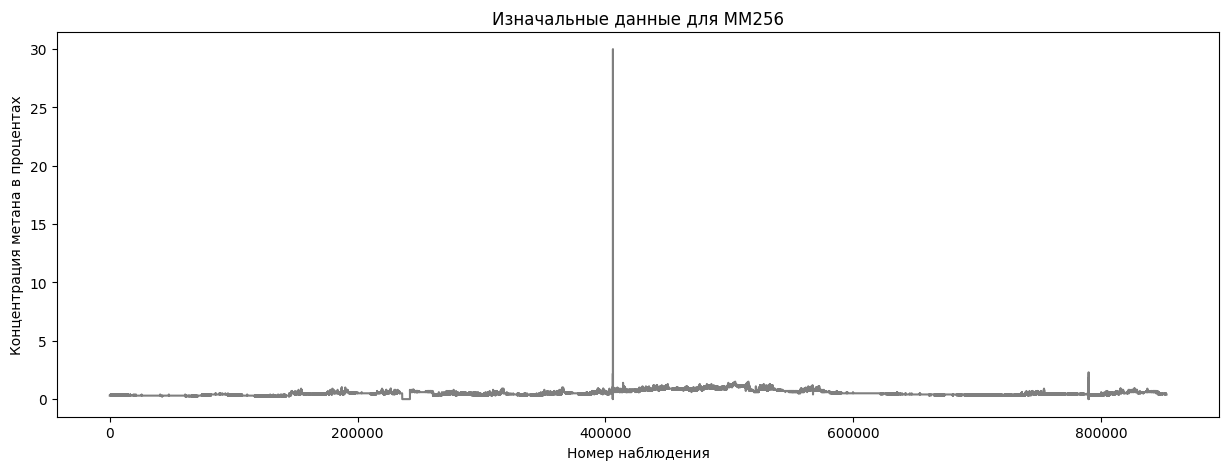

In [345]:
def plot_for_MM256(df):
    sec_from_start = range(len(df))
    plt.figure(figsize=(15, 5))
    plt.plot(sec_from_start, df['MM256'], color = 'black', alpha=0.5)
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Концентрация метана в процентах')
    

plot_for_MM256(df)
plt.title('Изначальные данные для MM256')

Видим большой выброс в районе $400 000$-ой секунды, а также выброс в районе $800 000$-ой секунды. 

Удалим выбросы, используя фильтр на верхнюю границу установленную в $1.6%$



Text(0.5, 1.0, 'Отчищенные от выбросов по верхней границе данные для MM256')

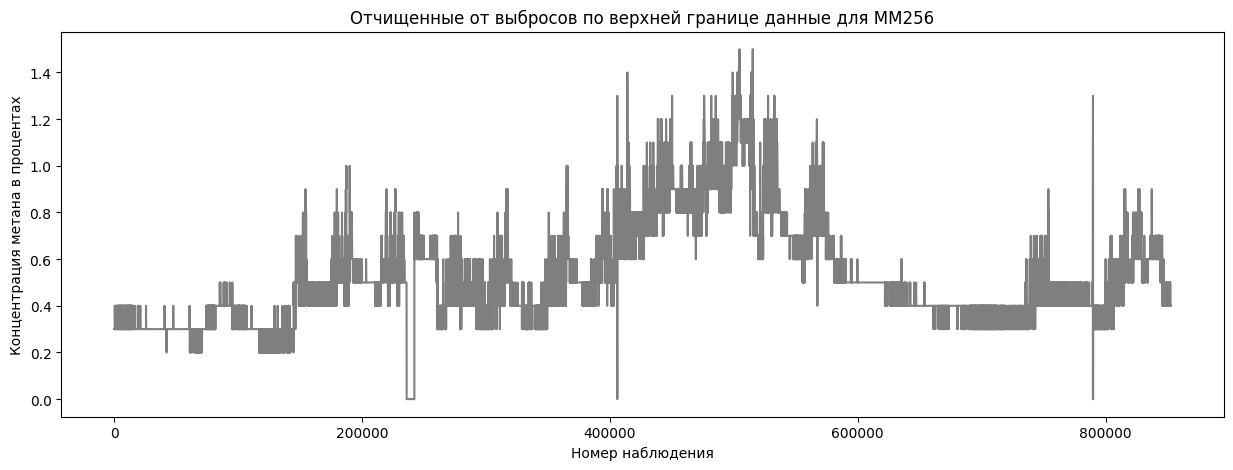

In [346]:
df = df.drop(df[(df['MM256'] > 1.6)].index)
plot_for_MM256(df)
plt.title('Отчищенные от выбросов по верхней границе данные для MM256')

Видим, что данные по нижней границе равны $0$ только в нескольких участках, это похоже на выброс. 

Удалим выбросы, используя фильтр на нижнюю границу установленную в $0.2%$

Text(0.5, 1.0, 'Отчищенные от выбросов по нижней границе данные для MM256')

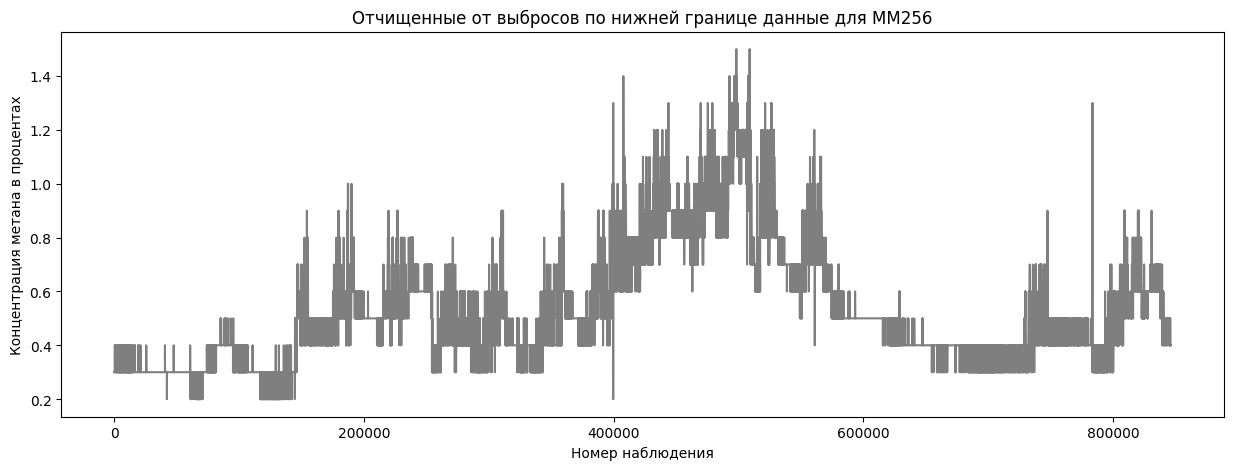

In [347]:
df = df.drop(df[(df['MM256'] < 0.2)].index)
plot_for_MM256(df)
plt.title('Отчищенные от выбросов по нижней границе данные для MM256')

Видим в части $800 000$ секунды график очень выбивается из средних значений.

Убирем этот выброос

Text(0.5, 1.0, 'Отчищенные от выбросов данные для MM256')

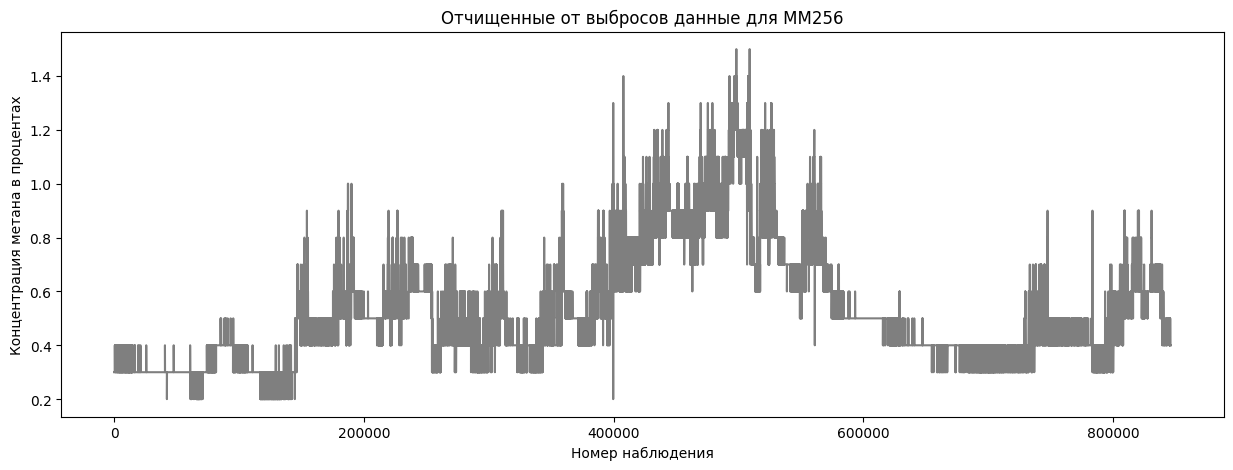

In [348]:
df = df.drop(df[(df.index > 700000) & (df['MM256'] > 1) ].index)

plot_for_MM256(df)
plt.title('Отчищенные от выбросов данные для MM256')


### Сглаживаем выборку с помощью экспоненциального фильтра

**Экспоненциальный фильтр**
$$X_{сг}(i) = X_{сг}(i - 1) + \alpha \cdot (X(i) - X_{сг}(i - 1)),$$
где $X_{сг}(i)$ – сглаженный сигнал; $\alpha$ – коэффициент фильтрации $∈ (0,1)$

Для простого сглаживания сигнала экспоненциальным фильтром можно использовать функцию библиотеки `pandas`. 

**Выборку сглаживаем дважды**.

In [349]:
df_filtered = df.copy()
df_filtered['MM256'] = df_filtered['MM256'].ewm(alpha=0.1).mean()
df_filtered['MM256'] = df_filtered['MM256'].ewm(alpha=0.01).mean()


График

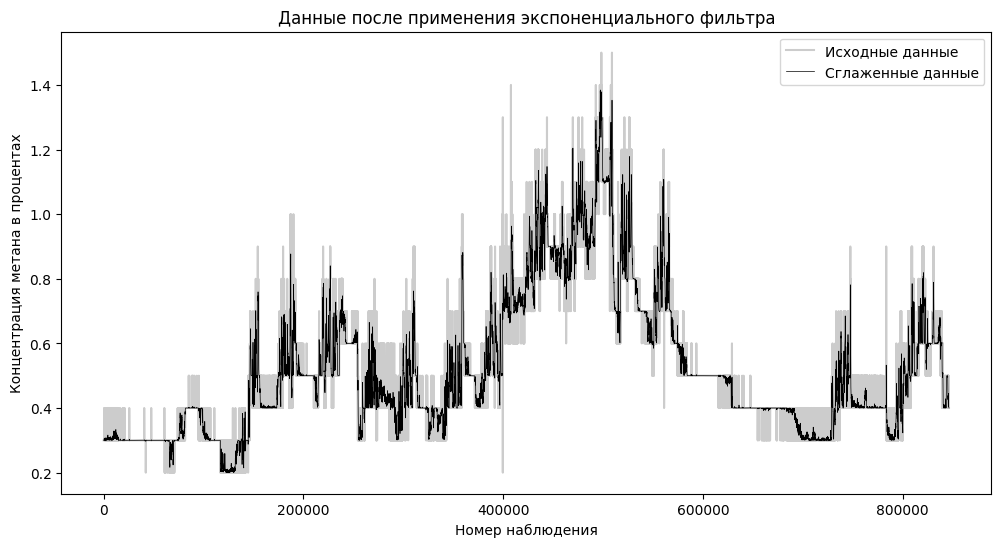

In [350]:
df_size = len(df)

sec_from_start = range(len(df))
plt.figure(figsize=(12, 6))

plt.plot(range(df_size), df['MM256'], label='Исходные данные', color = 'black', alpha=0.2)
plt.plot(range(df_size), df_filtered['MM256'], linewidth=0.5, color = 'black',  label='Сглаженные данные')

plt.xlabel('Номер наблюдения')
plt.ylabel('Концентрация метана в процентах')
plt.legend()
plt.title('Данные после применения экспоненциального фильтра')

plt.show()

In [351]:
df = df_filtered.copy()



### Удалим ненужные столбцы
Удаляем столбцы времени, поскольку они не будут являтmся факторами, влияющими на выходную переменную

In [352]:
data = df.copy()
data = data.drop(['year', 'month', 'day', 'hour', 'minute', 'second'], axis=1)

#### Проверим корреляцию с выходной переменной `MM256`

/var/folders/z8/wnyplhv16wx1zxfvhhzsvy5h0000gn/T/ipykernel_1787/1918453593.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pearson_corr.index, y=pearson_corr.values, palette='coolwarm')


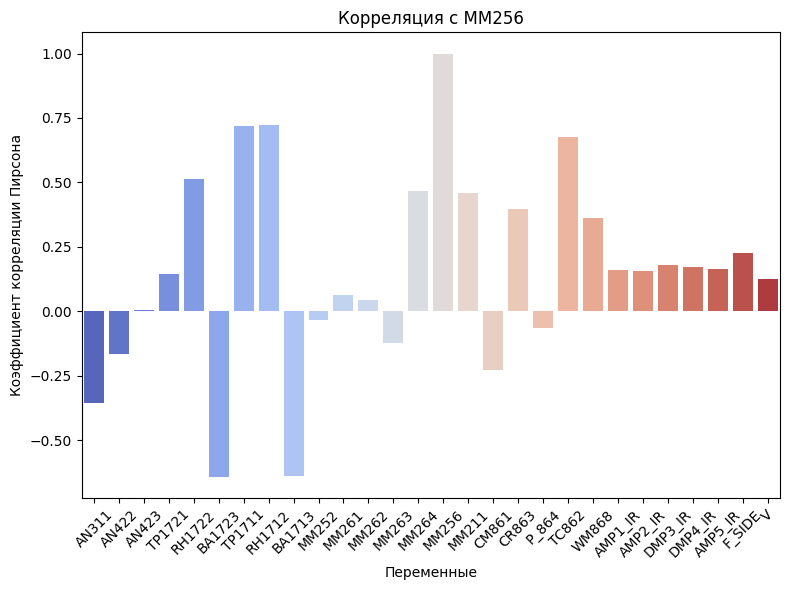

In [353]:
pearson_corr = data.corr()['MM256']


plt.figure(figsize=(8, 6))
sns.barplot(x=pearson_corr.index, y=pearson_corr.values, palette='coolwarm')
plt.title('Корреляция с MM256')
plt.xlabel('Переменные')
plt.ylabel('Коэффициент корреляции Пирсона')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Видим, что переменные `AN423`, `MM252`, `MM261`, `MM262`, `P_864` имеют низкую корреляцию с выходной переменной (меньше $0.1$). 

Поскольку мы проверили корреляцию по критерию Пирсона, проверим также наличие линейной зависимости между факторами со слабой корреляцией. 

Составим графики зависимости.

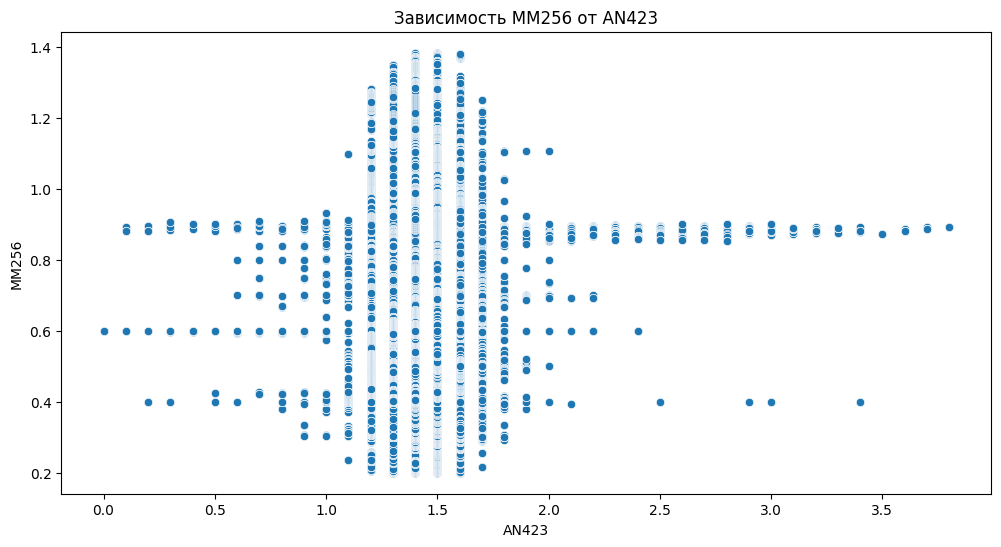

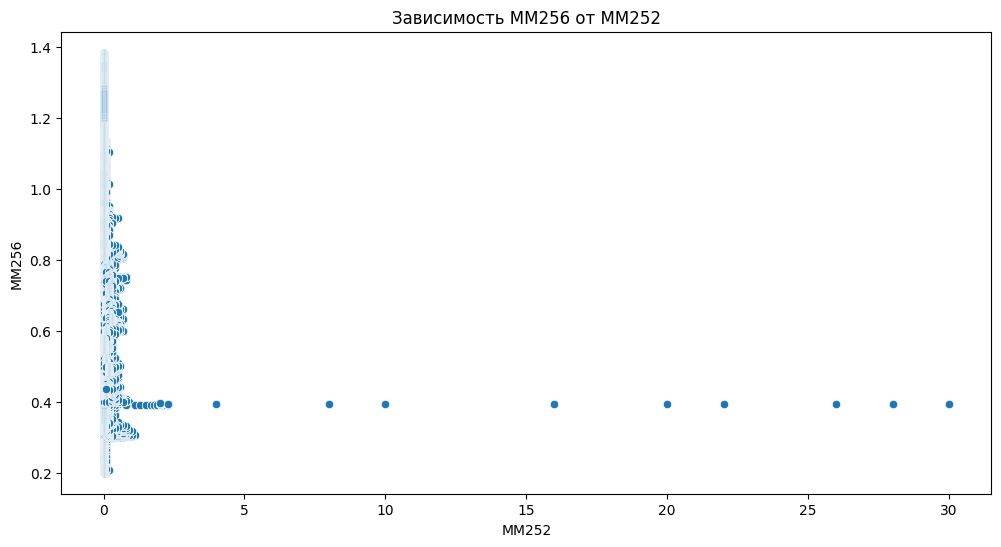

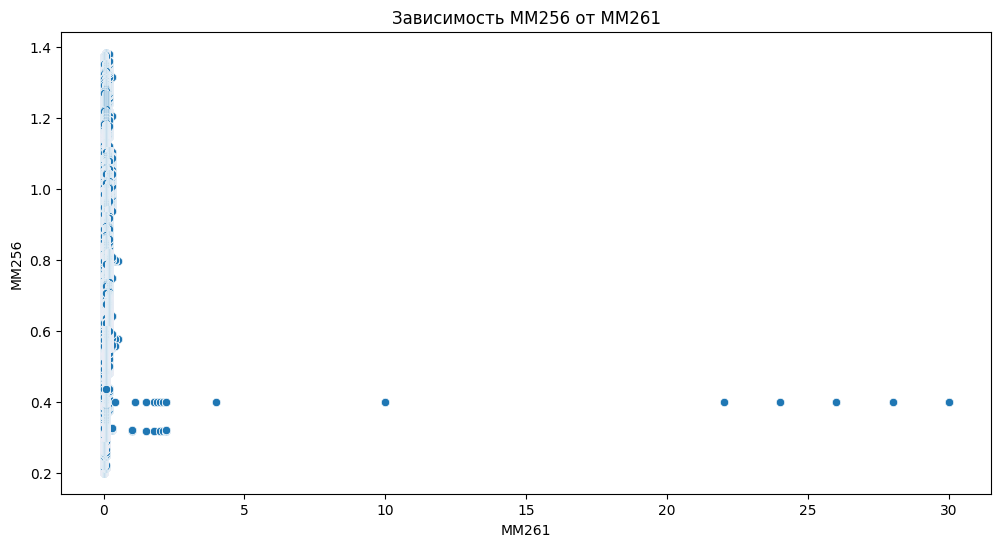

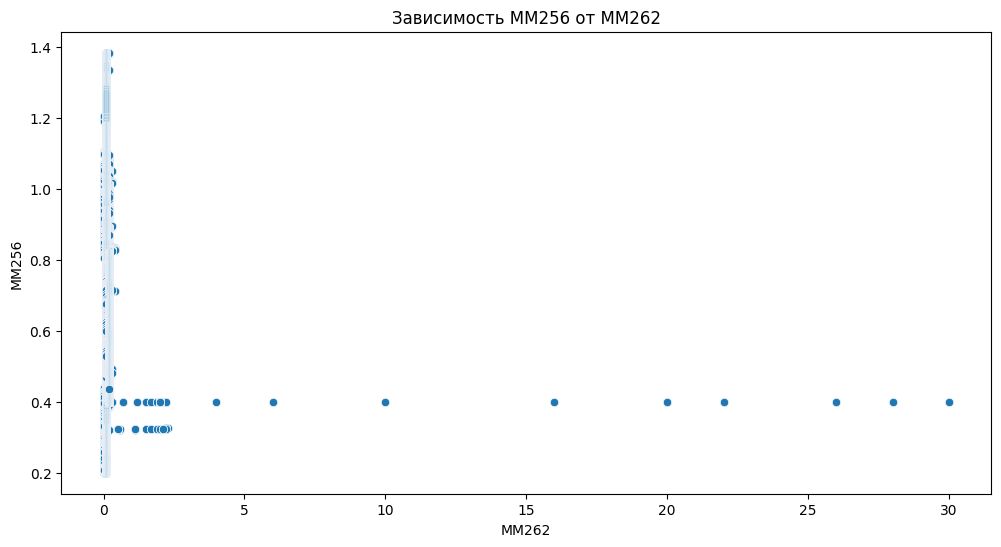

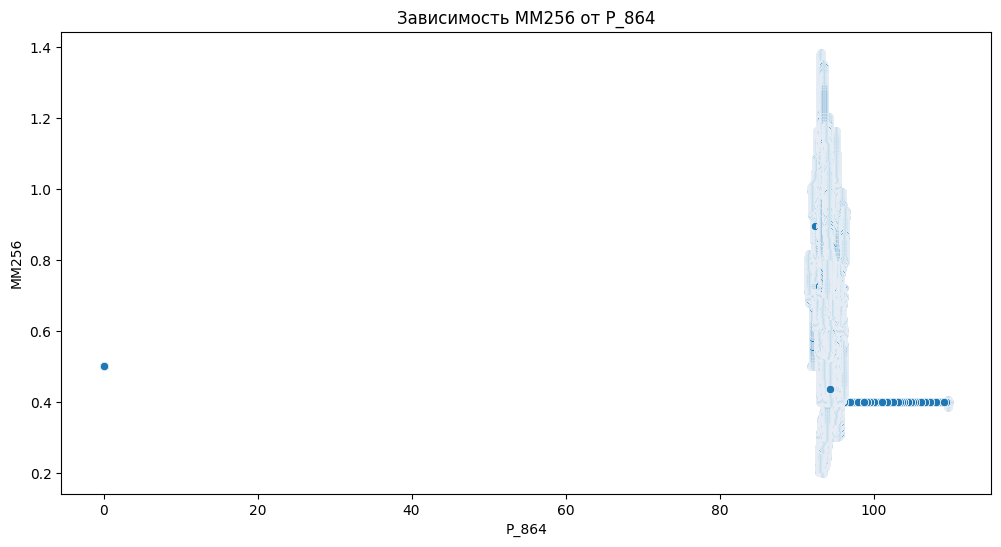

In [383]:
weak_pearson_corr = pearson_corr[pearson_corr.abs() < 0.1].index

for col in weak_pearson_corr:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=data[col], y=data['MM256'])
    plt.title(f'Зависимость MM256 от {col}')
    plt.xlabel(col)
    plt.ylabel('MM256')
    plt.show()


По графикам видно, что о линейной зависимости речи не идет, значит оставляем все факторы.

### Добавим интервал для предсказания
Добавим интервал сдвинутый на 15 минут вперед по времени. Удалим пропущеные значения.

In [367]:
interval = 15 * 60
data['y'] = data['MM256'].shift(-interval)
data.dropna(inplace=True)

## 4. Обучение модели

Для обучения модели будем использовать `PyTorch`

### Разделим выборку
#### На входные и выходные переменные

In [406]:
X = data.drop(columns='y')
y = data[['y']]

#### На тестовую и обучающую

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Масштабирование данных
Масштабируем признаки таким образом, чтобы они находились в определенном диапазоне, обычно от 0 до 1.

In [408]:
scaler = MinMaxScaler()
X_columns = X_train.columns
y_columns = y_train.columns

X_train[X_columns] = scaler.fit_transform(X_train[X_columns])
X_test[X_columns] = scaler.transform(X_test[X_columns])

y_train[y_columns] = scaler.fit_transform(y_train[y_columns])
y_test[y_columns] = scaler.transform(y_test[y_columns])
X_train

,AN311,AN422,AN423,TP1721,RH1722,BA1723,TP1711,RH1712,BA1713,MM252,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
384442,0.844444,0.789474,0.368421,0.960474,0.737705,0.987451,0.969799,0.814815,0.987533,0.000000,...,0.855191,0.940510,0.633174,0.052632,0.053498,0.300926,0.242424,0.076271,0.0,0.096
368803,0.822222,0.842105,0.394737,0.960474,0.737705,0.987989,0.986577,0.913580,0.987981,0.000000,...,0.857013,0.949008,0.653907,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000
147650,0.866667,0.842105,0.421053,0.968379,0.737705,0.990767,0.963087,0.901235,0.990851,0.000000,...,0.850638,0.926346,0.516746,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000
525472,0.755556,0.894737,0.421053,0.976285,0.852459,0.984851,0.989933,0.913580,0.985111,0.000000,...,0.850638,0.949008,0.649123,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000
654722,0.844444,0.789474,0.368421,0.976285,0.754098,0.991843,0.959732,0.802469,0.992017,0.000000,...,0.855191,0.926346,0.523126,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265484,0.777778,0.736842,0.394737,0.956522,0.770492,0.988706,0.969799,0.839506,0.988788,0.003333,...,0.857923,0.932011,0.722488,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000
372144,0.844444,0.789474,0.368421,0.960474,0.737705,0.987361,0.986577,0.864198,0.987353,0.003333,...,0.861566,0.951841,0.637959,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000
131932,0.844444,0.736842,0.394737,0.968379,0.721311,0.991484,0.953020,0.728395,0.991479,0.000000,...,0.849727,0.917847,0.531100,0.005061,0.005144,0.027778,0.020202,0.000000,0.0,0.000
683322,0.822222,0.789474,0.394737,0.972332,0.770492,0.993008,0.959732,0.790123,0.993004,0.000000,...,0.855191,0.926346,0.433812,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000


### Создадим свой датасет
Создадим кастомный класс для нашего датасета

In [409]:
class MethaneDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        feature = self.data.iloc[idx, :-1].values.astype(np.float32)
        target = self.data.iloc[idx, -1].reshape(-1).astype(np.float32)
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            target = self.target_transform(target)
        return feature, target

Создаем экземпляры класса

In [410]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_dataset = MethaneDataset(train_data, transform=torch.tensor,)
test_dataset = MethaneDataset(test_data, transform=torch.tensor,)

### Создадим даталоудер

Для того чтобы ускорить процесс обработки датасета, можно разрезать его на `batch`\`и и обработать параллельно.

Параметр shuffle() отвечает за случайное перемешивание выборки.

In [411]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Собираем нейросеть

In [412]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 65),
            nn.ReLU(),
            nn.Linear(65, 65),
            nn.ReLU(),
            nn.Linear(65, 65),
            nn.ReLU(),
            nn.Linear(65, output_size),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

### Тренируем нейросеть

#### Инициализируем модель

In [413]:
train_features, train_labels = next(iter(train_dataloader))

input_size = train_features.size()[1] 
output_size = train_labels.size()[1]

model = NeuralNetwork(input_size, output_size)

#### Инициализируем параметры
- шаг обучения
- количество эпох

In [414]:
learning_rate = 1e-3
epochs = 10

#### Функция потерь

In [415]:
loss_fn = nn.MSELoss() 

#### Инициализируем оптимизатор
В качестве оптимизатора берем оптимизатор Adam

In [416]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Цикл обучения модели

In [417]:
def train_loop(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    train_loss, train_mae, correct, total = 0, 0, 0, 0

    for X, y in dataloader:
        # Прямой проход: вычисление предсказаний
        pred = model(X)

        # Вычисление функции потерь
        loss = loss_fn(pred, y)  

        # Вычисление MAE
        mae = torch.mean(torch.abs(pred - y))

        # Обнуление градиентов
        optimizer.zero_grad()

        # Обратный проход: вычисление градиентов
        loss.backward()
        
        # Обновление параметров с использованием градиентного спуска
        optimizer.step()

        train_loss += loss.item()
        train_mae += mae.item()
        
        # Подсчет точности (Accuracy)
        correct += torch.sum(torch.abs(pred - y) <= 0.1).item()
        total += len(y)

    train_loss /= num_batches
    train_mae /= num_batches
    accuracy = (correct / total) * 100

    print(f"\nTrain Error: Avg loss: {train_loss:>8f}, Avg MAE: {train_mae:>8f}, Accuracy: {accuracy:>0.2f}%\n")
    return train_loss, train_mae, accuracy

#### Цикл тестирования модели

Метод no_grad() говорит, что через модель будут пропускаться данные, но градиент считаться не будет. Это нужно, чтобы модель не училась на тестовых данных.

In [418]:
def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, test_mae, correct, total = 0, 0, 0, 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            mae = torch.mean(torch.abs(pred - y))

            test_loss += loss.item()
            test_mae += mae.item()

            all_preds.append(pred)
            all_targets.append(y)
            
            correct += torch.sum(torch.abs(pred - y) <= 0.1).item()
            total += len(y)

    test_loss /= num_batches
    test_mae /= num_batches
    accuracy = (correct / total) * 100

    print(f"Test Error: Avg loss: {test_loss:>8f}, Avg MAE: {test_mae:>8f}, Accuracy: {accuracy:>0.2f}%\n")

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return test_loss, test_mae, all_preds, all_targets

### Сам цикл обучения

In [381]:
def training_cycle(model, epochs, loss_fn, optimizer):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
        
    print("Done!")

In [382]:
training_cycle(model, epochs, loss_fn, optimizer)


Epoch 1
-------------------------------

Train Error: Avg loss: 0.002931, Avg MAE: 0.033966, Accuracy: 92.17%

Test Error: Avg loss: 0.002610, Avg MAE: 0.033248, Accuracy: 92.87%

Epoch 2
-------------------------------

Train Error: Avg loss: 0.002388, Avg MAE: 0.030729, Accuracy: 93.59%

Test Error: Avg loss: 0.002376, Avg MAE: 0.029503, Accuracy: 93.23%

Epoch 3
-------------------------------

Train Error: Avg loss: 0.002238, Avg MAE: 0.029330, Accuracy: 94.04%

Test Error: Avg loss: 0.002343, Avg MAE: 0.030776, Accuracy: 93.60%

Epoch 4
-------------------------------

Train Error: Avg loss: 0.002126, Avg MAE: 0.028379, Accuracy: 94.42%

Test Error: Avg loss: 0.002061, Avg MAE: 0.027842, Accuracy: 94.69%

Epoch 5
-------------------------------

Train Error: Avg loss: 0.002018, Avg MAE: 0.027634, Accuracy: 94.81%

Test Error: Avg loss: 0.001935, Avg MAE: 0.026776, Accuracy: 95.04%

Epoch 6
-------------------------------

Train Error: Avg loss: 0.001922, Avg MAE: 0.026997, Accurac

### Визуализация для изначальных данных и для предсказанных

In [384]:
full_data = pd.concat([train_data, test_data], axis=0)
full_data.sort_index(inplace=True)

full_dataset = MethaneDataset(full_data, transform=torch.tensor,)

full_dataloader = DataLoader(full_dataset, batch_size=64, shuffle=False)
test_loss, test_mae, all_preds, all_targets = test_loop(full_dataloader, model, loss_fn)

Test Error: Avg loss: 0.001574, Avg MAE: 0.024144, Accuracy: 96.30%



#### Денормирование данных

In [385]:
all_preds = scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten() 
all_targets = scaler.inverse_transform(all_targets.reshape(-1, 1)).flatten()

#### График

In [404]:
def plot_results(all_targets, all_preds):
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets, label='Сглаженные значения', color = 'black', alpha=0.2)
    plt.plot(all_preds, linewidth=0.5, color = 'black',  label='Прогназируемые значения')
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Концентрация метана по MM256')
    plt.legend()
    plt.title('Сравнение сглаженных и прогнозируемых значений')

    plt.show()

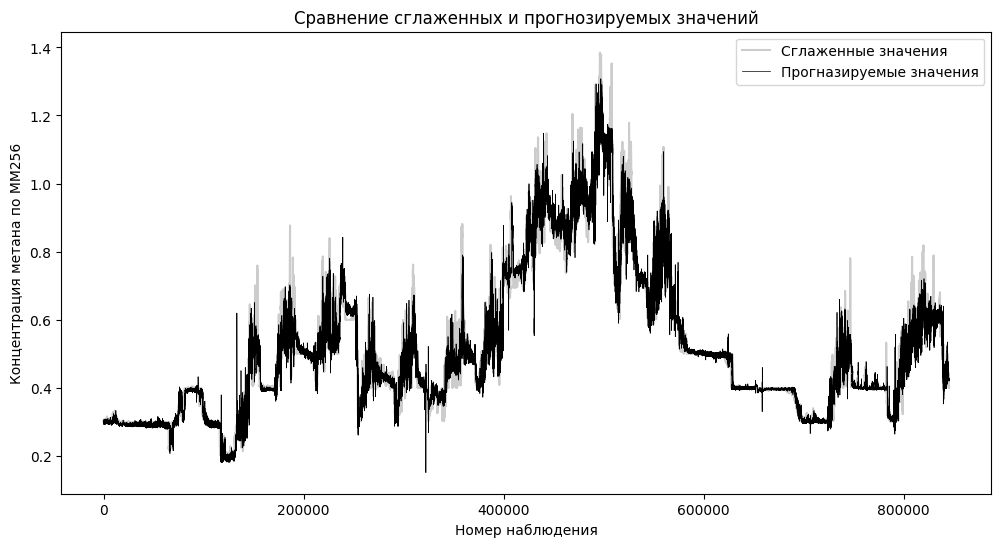

In [405]:
plot_results(all_targets, all_preds)